# **TESS LSTM Model**

In [ ]:
!jupyter nbconvert --to html /content/TESS_LSTM.ipynb

[NbConvertApp] Converting notebook /content/TESS_LSTM.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 18 image(s).
[NbConvertApp] Writing 3083413 bytes to /content/TESS_LSTM.html


#  <center> Importing <center>

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# Install the latest version of TensorFlow
!pip install -q tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.1 MB/s eta 0:00:00


#  <center> Datasets <center>

In [ ]:
import os
from google.colab import files

# Upload your kaggle.json file (from https://www.kaggle.com/docs/api)
uploaded = files.upload()

# Create the Kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Move the uploaded kaggle.json file to the .kaggle folder
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

# Set permissions for the file
os.chmod('/root/.kaggle/kaggle.json', 600)


Saving kaggle.json to kaggle.json


In [ ]:
# Download the Ravdess Emotional Speech Audio dataset
#!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

# Download the Toronto Emotional Speech Set (TESS) dataset
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

# Download the CREMAD dataset
#!kaggle datasets download -d ejlok1/cremad

# Download the Surrey Audiovisual Expressed Emotion (SAVEE) dataset
# !kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee


Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)


In [ ]:
import zipfile

# Extract each dataset (you can change the dataset name if necessary)
# '''with zipfile.ZipFile('ravdess-emotional-speech-audio.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/ravdess')

with zipfile.ZipFile('toronto-emotional-speech-set-tess.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tess')

# with zipfile.ZipFile('cremad.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/cremad')'''

# with zipfile.ZipFile('surrey-audiovisual-expressed-emotion-savee.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/savee')


In [ ]:
# Paths for data in Colab
Tess = "/content/tess/TESS Toronto emotional speech set data/"

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        if file.endswith('.wav'):
            emotion_part = file.split('_')[-1].replace('.wav', '')  # Get the last segment
        else:
            emotion_part = 'Unknown'  # If not a .wav file

            # Map the emotion
        if emotion_part == "ps":
            file_emotion.append('surprise')
        elif emotion_part == "sad":
            file_emotion.append('sad')
        elif emotion_part == "angry":
            file_emotion.append('angry')
        elif emotion_part == "disgust":
            file_emotion.append('disgust')
        elif emotion_part == "fear":
            file_emotion.append('fear')
        elif emotion_part == "happy":
            file_emotion.append('happy')
        elif emotion_part == "neutral":
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')
        #else:
        #    file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,disgust,/content/tess/TESS Toronto emotional speech se...
1,disgust,/content/tess/TESS Toronto emotional speech se...
2,disgust,/content/tess/TESS Toronto emotional speech se...
3,disgust,/content/tess/TESS Toronto emotional speech se...
4,disgust,/content/tess/TESS Toronto emotional speech se...


In [ ]:
data_path = pd.concat([Tess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,disgust,/content/tess/TESS Toronto emotional speech se...
1,disgust,/content/tess/TESS Toronto emotional speech se...
2,disgust,/content/tess/TESS Toronto emotional speech se...
3,disgust,/content/tess/TESS Toronto emotional speech se...
4,disgust,/content/tess/TESS Toronto emotional speech se...


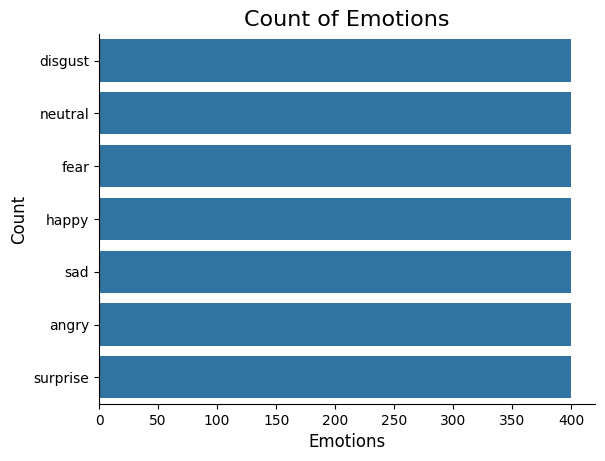

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

#  <center> Waveplot - loudness <center>
#  <center> Spectogram - frequency <center>

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

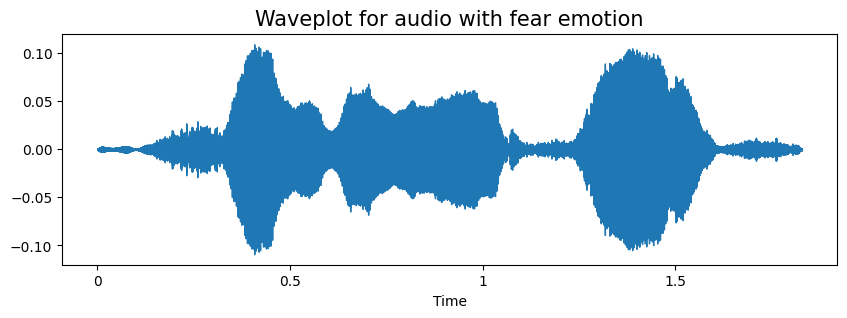

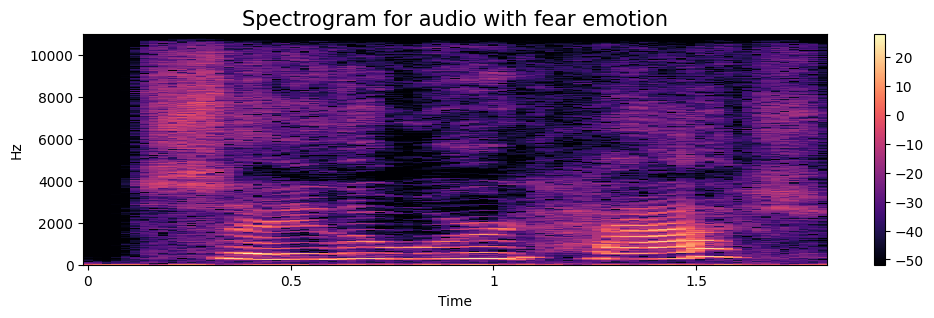

In [ ]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

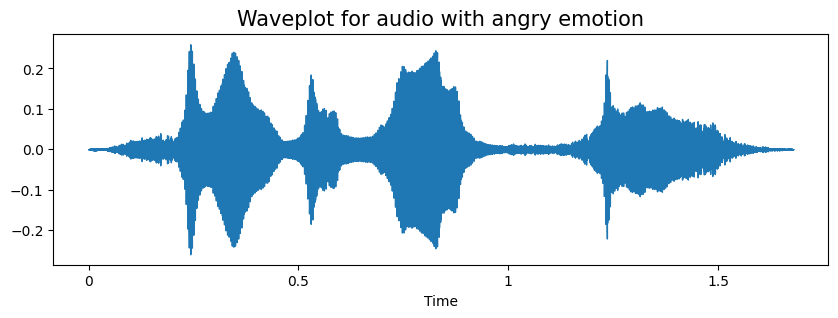

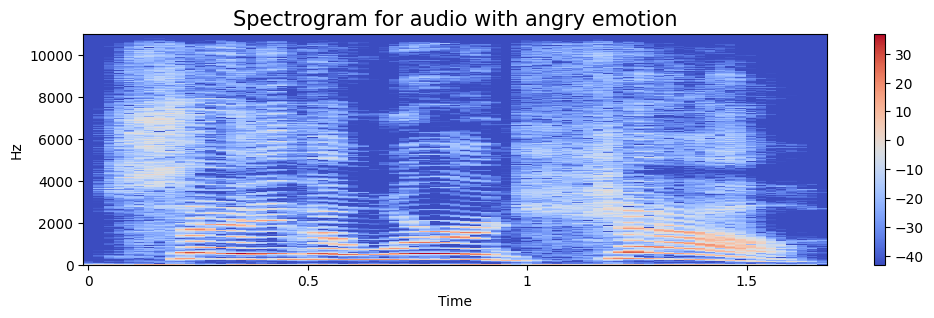

In [ ]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

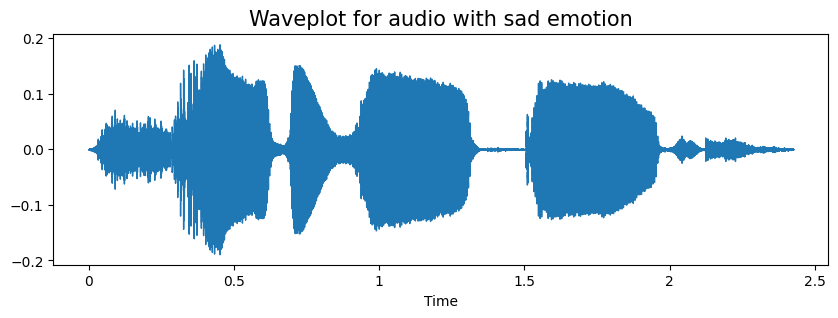

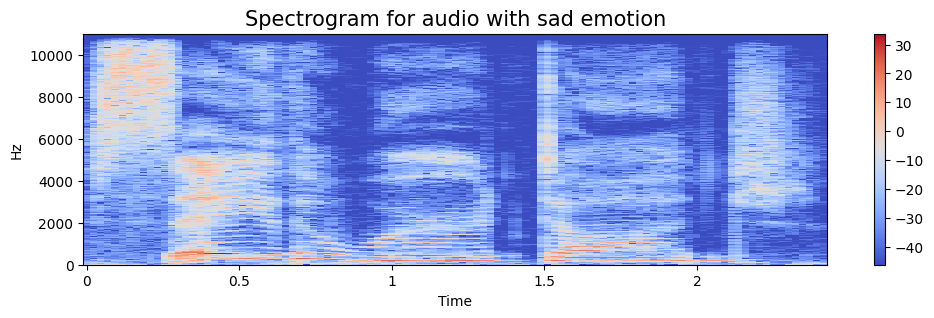

In [ ]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

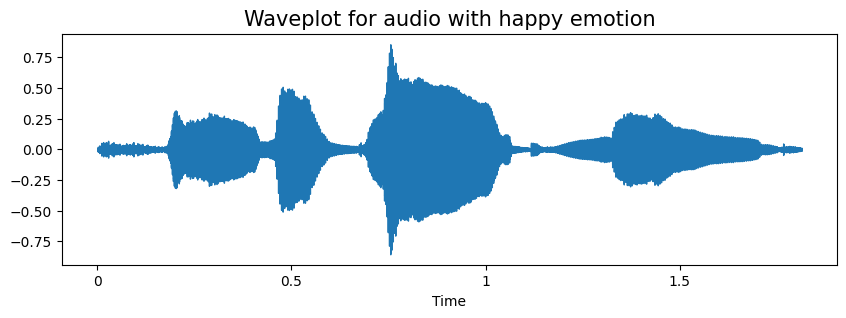

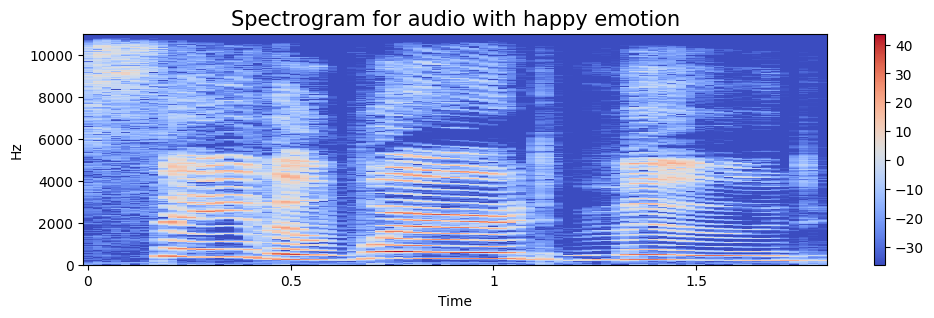

In [ ]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

#  <center> Data Augmentation <center>

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)  # Use keyword argument for sr

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

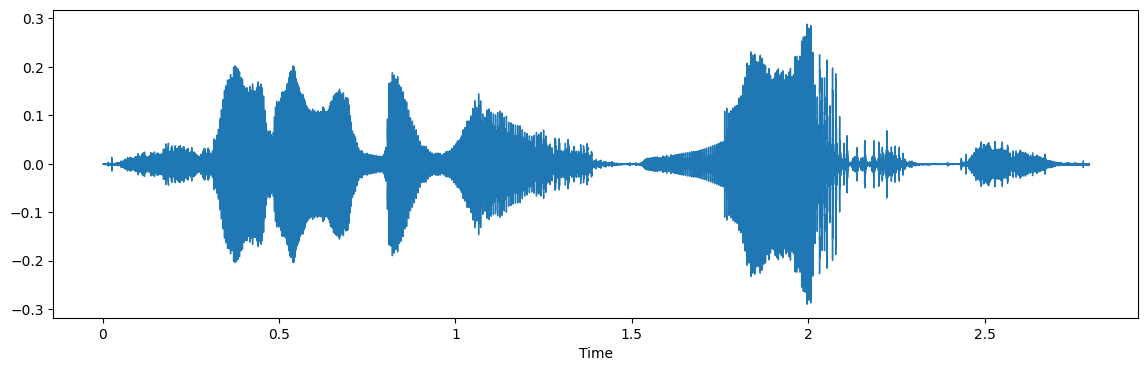

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

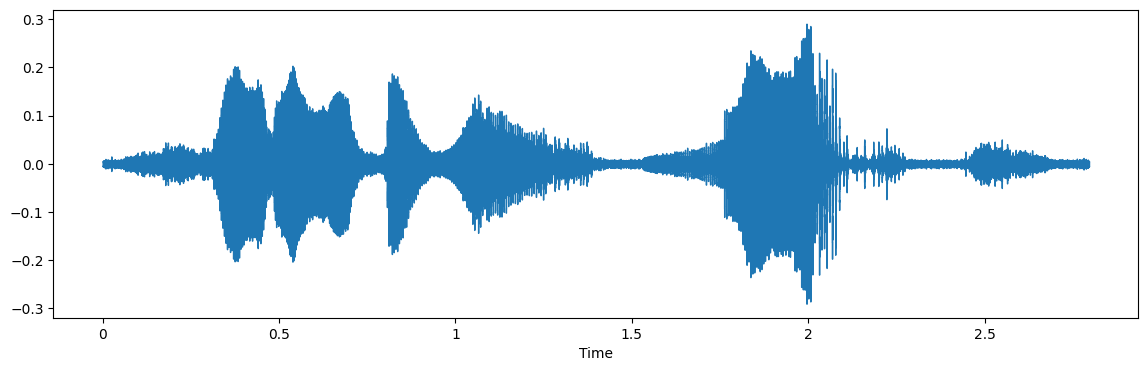

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

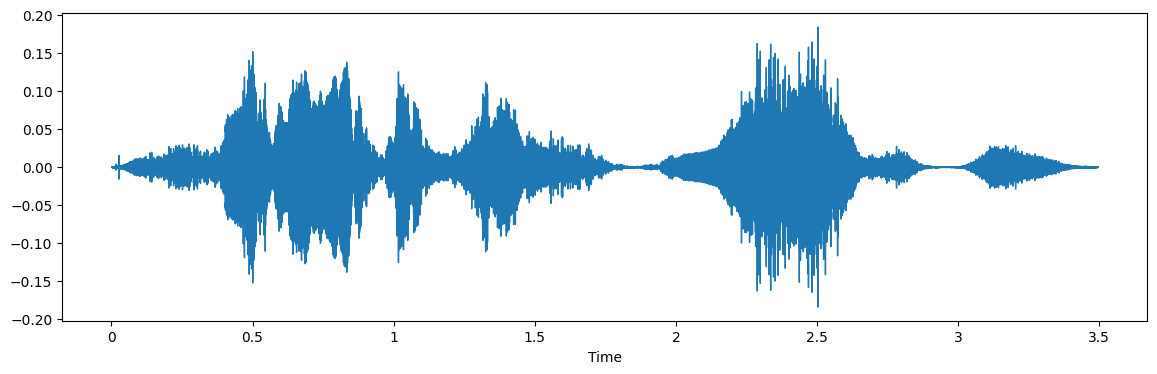

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

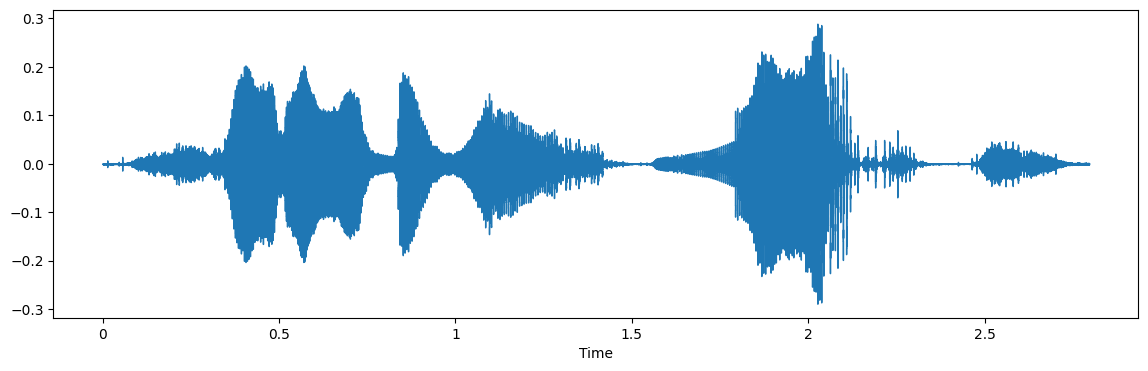

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

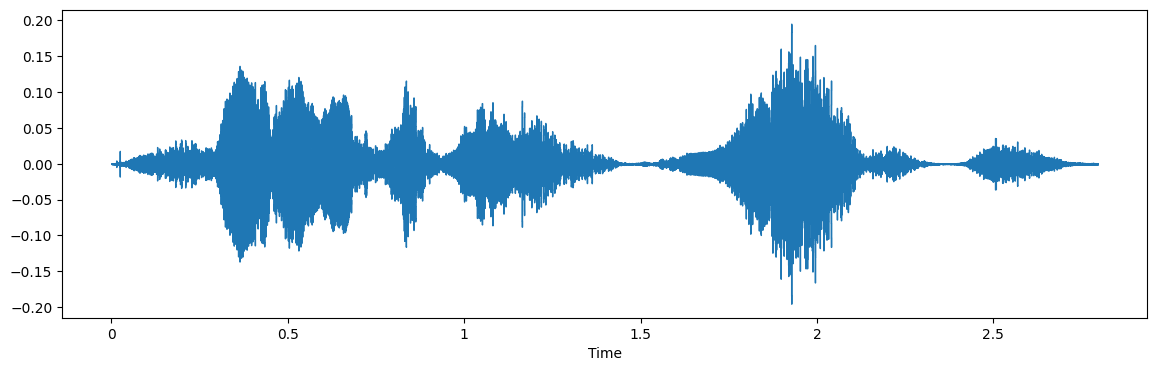

In [ ]:
x = pitch(data, sample_rate, 0.7)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#  <center> Feature Extraction <center>

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

# LSTM Dump till Before Model

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
#import time

# Combine emotion labels from each dataframe
#labels = list(Ravdess_df['Emotions']) + list(Crema_df['Emotions']) + list(Tess_df['Emotions']) + list(Savee_df['Emotions'])
labels = list(Tess_df['Emotions'])

# Encode labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
onehot_encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output instead of sparse
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

# Combine paths from all dataframes
#paths = '''list(Ravdess_df['Path']) + list(Crema_df['Path']) + list(Tess_df['Path']) +''' list(Savee_df['Path'])
paths = list(Tess_df['Path'])

features = []

for path in paths:

    feature_set = get_features(path)

    if feature_set is not None and len(feature_set) > 0:
        features.append(feature_set)


print(f"Number of features extracted: {len(features)}")

# Trim y to match the number of features
y = y[:len(features)]

# Convert to NumPy array and prepare for model input
features = np.array(features)
features = features.reshape(features.shape[0], -1)  # Flatten for standard scaling

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(features)

# Reshape X to be 3D for LSTM input: (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Number of features extracted: 2800


# LSTM Base Model

In [ ]:
# Define the LSTM model
model = Sequential()

# First LSTM layer with Dropout and Batch Normalization
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Second LSTM layer
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Fully connected dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output layer with softmax activation
model.add(Dense(y.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model checkpoint to save the best model during training
checkpoint = ModelCheckpoint('best_lstm_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[checkpoint])

# Load the best model
model.load_weights('best_lstm_model.keras')

# Evaluate the model on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# Print the accuracy of the model on test data
accuracy = model.evaluate(X_test, y_test)[1] * 100
print("Accuracy of our model on test data : ", accuracy, "%")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 58s 959ms/step - accuracy: 0.1903 - loss: 2.1725 - val_accuracy: 0.2121 - val_loss: 1.9280
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 53s 946ms/step - accuracy: 0.2153 - loss: 1.9570 - val_accuracy: 0.2232 - val_loss: 1.8640
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 53s 941ms/step - accuracy: 0.2398 - loss: 1.8722 - val_accuracy: 0.1496 - val_loss: 1.8887
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 936ms/step - accuracy: 0.1964 - loss: 1.9245 - val_accuracy: 0.1629 - val_loss: 1.9384
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 53s 940ms/step - accuracy: 0.2480 - loss: 1.8451 - val_accuracy: 0.2545 - val_loss: 1.8456
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 938ms/step - accuracy: 0.2639 - loss: 1.7951 - val_accuracy: 0.2433 - val_loss: 1.8706
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 53s 944ms/step - accuracy: 0.2672 - loss: 1.7736 - val_accuracy: 0.2522 - val_loss: 2.0090
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 53s 950ms/step - accuracy: 0.2732 - loss: 1.6974 - val_accuracy: 0.287

18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 315ms/step


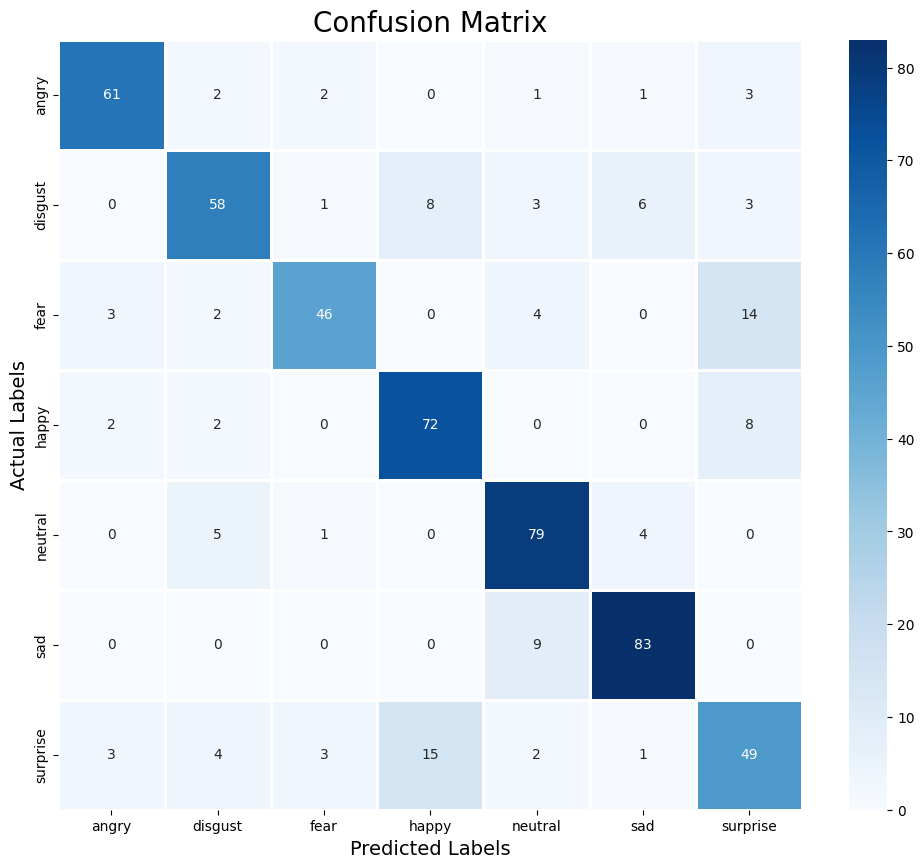

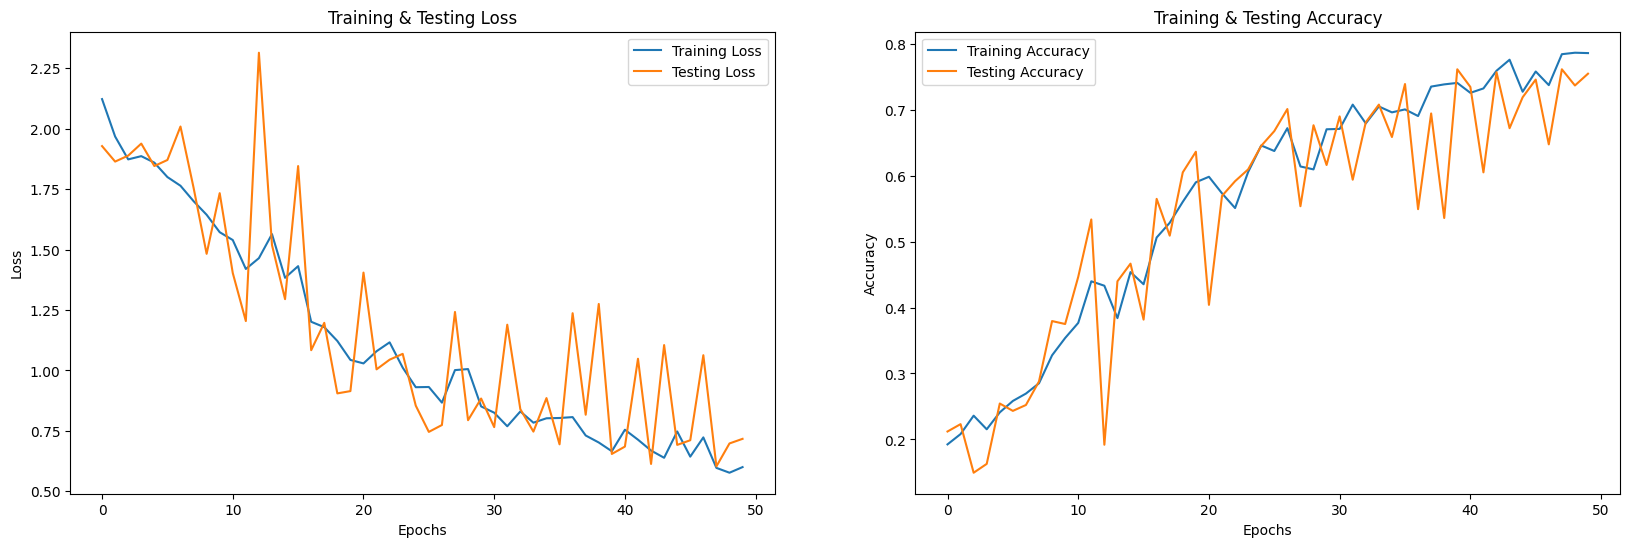

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 10))

# Modify the line below according to your label encoder
cm = pd.DataFrame(cm, index=[i for i in label_encoder.classes_], columns=[i for i in label_encoder.classes_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='g')  # Use 'g' for integer annotation
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

# Plotting training and testing loss and accuracy
epochs = [i for i in range(len(history.history['loss']))]  # Update to the number of epochs used
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20, 6)

# Plot for Loss
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

# Plot for Accuracy
ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")

plt.show()

New Preprocessing


In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 1. Convert to NumPy arrays
X = np.array(X)
Y = np.array(Y)

# 2. Encode labels (e.g., 'happy', 'sad') to integers
le = LabelEncoder()
Y = le.fit_transform(Y)

# 3. One-hot encode labels
Y = to_categorical(Y)

# 4. Reshape X if needed (samples, timesteps, features)
# If each `feature` is already a 2D array, we assume X shape is already OK
# But often, X is (samples, features), so we reshape to (samples, timesteps=1, features)
if len(X.shape) == 2:
    X = X.reshape(X.shape[0], 1, X.shape[1])

# 5. Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Check shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


X_train shape: (6720, 1, 162)
y_train shape: (6720, 7)
X_val shape: (1680, 1, 162)
y_val shape: (1680, 7)


New LSTM with Batch Normalization, early dropout, L2 regularization


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Strategy 4: Using a reduced learning rate with Adam optimizer
opt = Adam(learning_rate=0.0005)

# Model building
model = Sequential()

# First LSTM layer with return_sequences=True
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization())  # Strategy 3: Added BatchNormalization
model.add(Dropout(0.4))          # Strategy 2: Dropout layer

# Second LSTM layer
model.add(LSTM(units=128, return_sequences=False))
model.add(BatchNormalization())  # Strategy 3: Added BatchNormalization
model.add(Dropout(0.4))          # Strategy 2: Dropout layer

# Fully connected layer with L2 regularization
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # Strategy 1: L2 regularization
model.add(Dropout(0.4))                                               # Strategy 2: Dropout again

# Output layer
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │       148,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 290,311 (1.11 MB)

 Trainable params: 289,799 (1.11 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
from keras.callbacks import EarlyStopping

# Strategy 1: EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],  # Added callback here
    verbose=1
)


Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.2866 - loss: 2.8727 - val_accuracy: 0.6018 - val_loss: 2.3784
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5795 - loss: 1.7911 - val_accuracy: 0.8321 - val_loss: 1.3215
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6985 - loss: 1.3851 - val_accuracy: 0.8726 - val_loss: 0.8546
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7502 - loss: 1.1332 - val_accuracy: 0.8875 - val_loss: 0.6700
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7799 - loss: 0.9532 - val_accuracy: 0.9190 - val_loss: 0.5631
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8247 - loss: 0.7777 - val_accuracy: 0.9089 - val_loss: 0.4885
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8392 - loss: 0.6956 - val_accuracy: 0.9179 - val_loss: 0.3895
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8705 - loss: 0.5616 - val_accuracy: 0.


Strategy	How it helped
1. More LSTM units (128)	Increased capacity to learn patterns in audio features
2. Dropout layers (0.4)	Reduced overfitting by randomly deactivating neurons during training
3. BatchNormalization	Helped the model converge faster and more stably
4. EarlyStopping	Prevented unnecessary training once validation loss stopped improving
More training data (via augmentation)	Helped model generalize better across variations

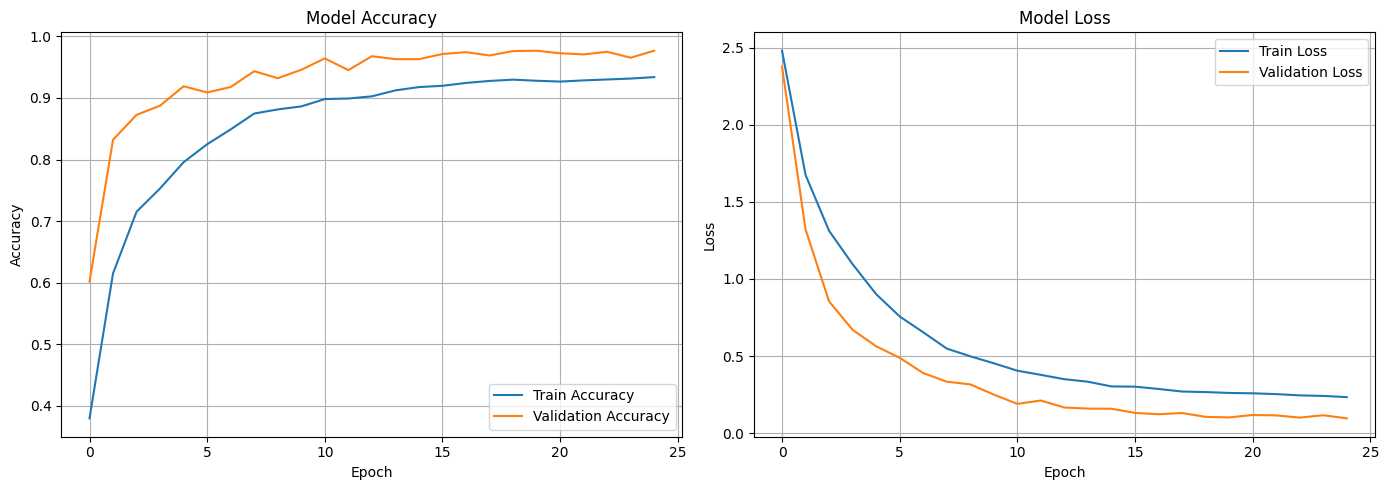

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


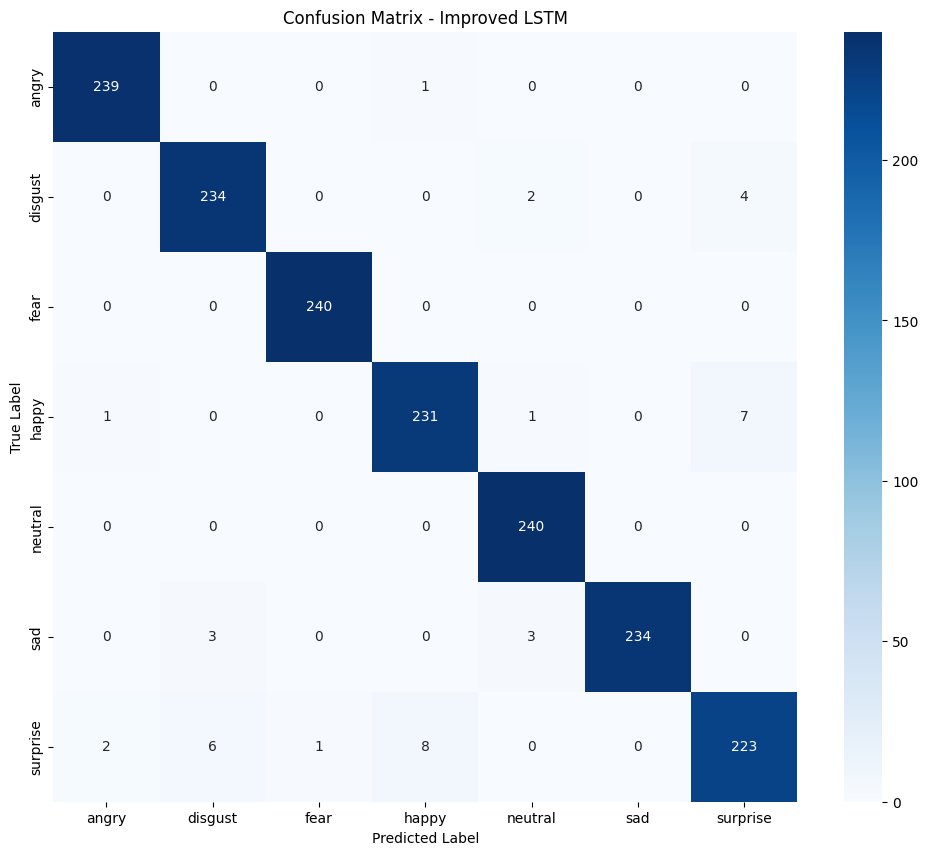


Classification Report:

              precision    recall  f1-score   support

       angry       0.99      1.00      0.99       240
     disgust       0.96      0.97      0.97       240
        fear       1.00      1.00      1.00       240
       happy       0.96      0.96      0.96       240
     neutral       0.98      1.00      0.99       240
         sad       1.00      0.97      0.99       240
    surprise       0.95      0.93      0.94       240

    accuracy                           0.98      1680
   macro avg       0.98      0.98      0.98      1680
weighted avg       0.98      0.98      0.98      1680



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Emotion labels from the label encoder
emotion_labels = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.title("Confusion Matrix - Improved LSTM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=emotion_labels))
